# Deploy a trained model on the test set

## Set model_path

In [73]:
# Put path to model here
model_path = 'outputs/2024-03-11_015721/best/best_model.pth' # Default path

## Visualize the train-validation-test split of the data

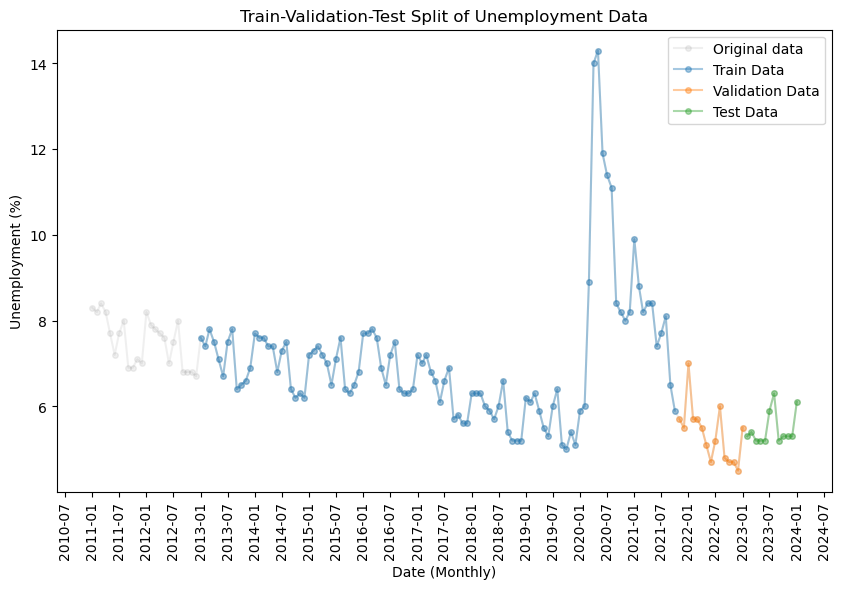

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from run_rnn import *
import matplotlib.dates as mdates


# Load the model
model_path =  torch.load(model_path)

# Extract seq_length
seq_length = model_path['seq_length']

# Preprocess and split the data
data_cleaned, data_unscaled, scaler = get_preprocessed_data()
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data=data_cleaned,seq_length=seq_length)

# Visualize the train-validation-test split of the data using matplotlib
plt.figure(figsize=(10, 6))
# Plot original data
plt.plot(data_unscaled.index, data_unscaled["Unemployment"], label='Original data', alpha=0.12, marker='o',markersize=4, color='gray')

# Plot "Train Data"
plt.plot(data_unscaled.index[seq_length:X_train.shape[0]+seq_length], scaler.inverse_transform(y_train), label='Train Data',alpha=0.4, marker='o',markersize=4)

# Plot "Validation Data"
plt.plot(data_unscaled.index[X_train.shape[0]+seq_length:X_train.shape[0]+X_val.shape[0]+seq_length], scaler.inverse_transform(y_val), label='Validation Data',alpha=0.4, marker='o',markersize=4)

# Plot "Test Data"
plt.plot(data_unscaled.index[seq_length+X_train.shape[0]+X_val.shape[0]:], data_unscaled[X_train.shape[0]+X_val.shape[0]+seq_length:], label='Test Data',alpha=0.4, marker='o',markersize=4)

# Add labels, title, and legend
plt.xlabel('Date (Monthly)')
plt.ylabel('Unemployment (%)')
plt.title('Train-Validation-Test Split of Unemployment Data')
plt.legend()

# Formatting x-axis ticks to display month and year
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()



## Evaluate the model


HYPERPARAMETERS FOR SELECTED MODEL
Epoch: 598/3000
Hidden Size: 200
Learning Rate: 0.001
Batch Size: 64
Sequence Length: 24

Training Loss (MSE): 0.0008088021422736347
Validation Loss (MSE): 0.003326789475977421
Root Mean Squared Error (RMSE): 1.4560185226037183
Mean Absolute Error (MAE): 0.78
Mean Absolute Percentage Error (MAPE): 13.63%


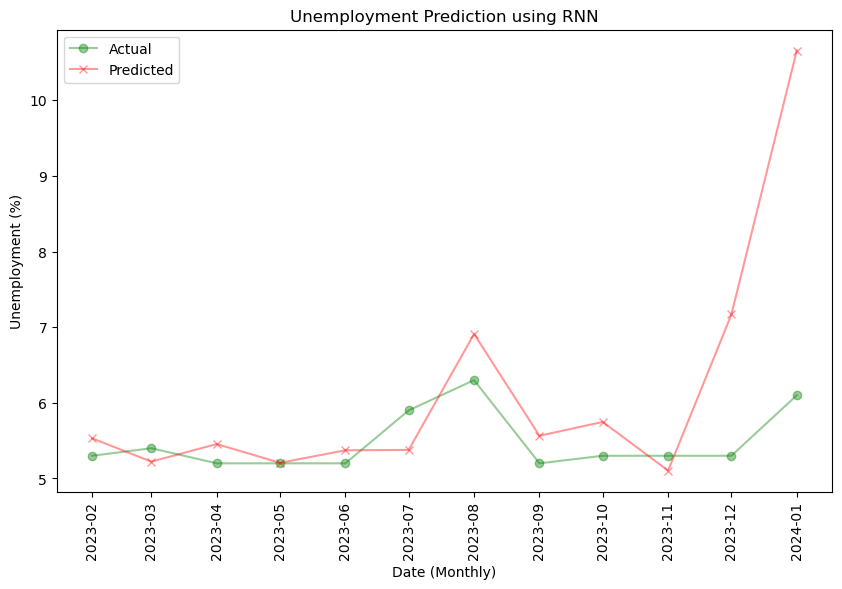

In [75]:
# Load best model
model = RNNModel(input_size=1, hidden_size=model_path['hidden_size'], output_size=1)
model.load_state_dict(model_path['model_state_dict'])

# Evaluate model on the test data
model.eval() 
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler.inverse_transform(y_pred_test)
    y_test = scaler.inverse_transform(y_test)

# Print hyperparameters of the selected model to console
print("\n==================================")
print("HYPERPARAMETERS FOR SELECTED MODEL")
print("Epoch:", f"{model_path['epoch']}/{model_path['total_epochs']}")
print("Hidden Size:", model_path['hidden_size'])
print("Learning Rate:", model_path['learning_rate'])
print("Batch Size:", model_path['batch_size'])
print("Sequence Length:", model_path['seq_length'])
print("\n==================================")
print("Training Loss (MSE):", model_path['train_loss'])
print("Validation Loss (MSE):", model_path['val_loss'])
# Calculate RMSE and print to console
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, y_pred_test)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# Visualize predictions on test set using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(data_unscaled.index[X_train.shape[0]+X_val.shape[0]+seq_length:], y_test, label='Actual',alpha=0.4, marker='o',color='green')
plt.plot(data_unscaled.index[X_train.shape[0]+X_val.shape[0]+seq_length:], y_pred_test, label='Predicted',alpha=0.4, marker='x',color='red')
plt.xlabel('Date (Monthly)')
plt.ylabel('Unemployment (%)')
plt.title('Unemployment Prediction using RNN')
plt.legend()

# Formatting x-axis ticks to display month and year
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()
